## Detecció de Outliders

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

from scipy.stats import zscore, chi2


outliers_path = 'outliers_results/outliers'
data_path = 'outliers_results/datasets'
os.makedirs(outliers_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

def detect_outliers_iqr(data, column, threshold=1.15):
    data = data.copy()
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    data['iqr_outlier'] = (data[column] < lower_bound) | (data[column] > upper_bound)
    outliers = data[data['iqr_outlier']]
    return outliers

def detect_outliers_zscore(data, column, threshold=4):
    data = data.copy()
    data['z_score'] = zscore(data[column])
    outliers = data[abs(data['z_score']) > threshold]
    return outliers

def detect_outliers_isolation_forest(data, columns, contamination=0.09):
    data = data.copy()
    model = IsolationForest(contamination=contamination, random_state=42)
    data['anomaly'] = model.fit_predict(data[columns])
    outliers = data[data['anomaly'] == -1]
    return outliers

def detect_outliers_dbscan(data, columns, eps=0.5, min_samples=5):
    data = data.copy()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[columns])
    model = DBSCAN(eps=eps, min_samples=min_samples)
    data['cluster'] = model.fit_predict(scaled_data)
    outliers = data[data['cluster'] == -1]
    return outliers

def detect_outliers_mahalanobis(data, columns, threshold=0.05):
    data = data.copy()
    cov_matrix = data[columns].cov().values
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean = data[columns].mean().values

    def calculate_mahalanobis(row):
        diff = row - mean
        return np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff.T))

    data['mahalanobis'] = data[columns].apply(calculate_mahalanobis, axis=1)
    chi2_threshold = chi2.ppf(threshold, df=len(columns))
    outliers = data[data['mahalanobis'] > chi2_threshold]
    return outliers

def get_outliers_datasets(data, numeric_columns):
    outliers_datasets = {}

    # IQR
    outliers_iqr = pd.DataFrame()
    for col in numeric_columns:
        outliers_iqr = pd.concat([outliers_iqr, detect_outliers_iqr(data, col)])
    outliers_datasets['IQR'] = outliers_iqr.drop_duplicates()

    # Z-Score
    outliers_zscore = pd.DataFrame()
    for col in numeric_columns:
        outliers_zscore = pd.concat([outliers_zscore, detect_outliers_zscore(data, col)])
    outliers_datasets['Z-Score'] = outliers_zscore.drop_duplicates()

    # Isolation Forest
    outliers_if = detect_outliers_isolation_forest(data, numeric_columns)
    outliers_datasets['Isolation Forest'] = outliers_if

    # DBSCAN
    outliers_dbscan = detect_outliers_dbscan(data, numeric_columns)
    outliers_datasets['DBSCAN'] = outliers_dbscan

    # Mahalanobis
    outliers_mahalanobis = detect_outliers_mahalanobis(data, numeric_columns)
    outliers_datasets['Mahalanobis'] = outliers_mahalanobis

    return outliers_datasets

def export_to_csv(outliers_datasets, folder):
    for method, df in outliers_datasets.items():
        file_path = os.path.join(folder, f"{method}_outliers.csv")
        df.to_csv(file_path, index=True)

def export_clean_data(data, outliers_datasets, folder):
    for method, outliers_df in outliers_datasets.items():
        clean_data = data[~data.index.isin(outliers_df.index)]
        file_path = os.path.join(folder, f"{method}_clean_data.csv")
        clean_data.to_csv(file_path, index=True)

def show_results(outliers_datasets):
    print("\n--- Panel de Información de Outliers ---")
    for method, df in outliers_datasets.items():
        print(f"\nMétodo: {method}")
        print(f"Número de outliers detectados: {len(df)}")

file = "../res/dataset_cleaned.csv"
df = pd.read_csv(file)
df.set_index('_id', inplace=True)

numeric_columns = df.select_dtypes(include=['float64']).columns
outliers_datasets = get_outliers_datasets(df, numeric_columns)

show_results(outliers_datasets)

export_to_csv(outliers_datasets, outliers_path)

export_clean_data(df, outliers_datasets, data_path)



--- Panel de Información de Outliers ---

Método: IQR
Número de outliers detectados: 789

Método: Z-Score
Número de outliers detectados: 99

Método: Isolation Forest
Número de outliers detectados: 85

Método: DBSCAN
Número de outliers detectados: 765

Método: Mahalanobis
Número de outliers detectados: 59


## Model de regresió

In [80]:
def aplicar_onehotencoder(df, columnas_object = None):
    if not columnas_object: 
        columnas_object = df.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_data = encoder.fit_transform(df[columnas_object])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columnas_object))
    encoded_df.index = df.index
    return encoded_df, encoder

def aplicar_standardscaler(df, columnas_numericas=None):
    if columnas_numericas is None:
        columnas_numericas = df.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[columnas_numericas])
    scaled_df = pd.DataFrame(scaled_data, columns=columnas_numericas, index=df.index)
    return scaled_df, scaler

data = pd.read_csv("../res/dataset_final.csv")
data = data.set_index("_id")

df_onehot, encoder_ohe = aplicar_onehotencoder(data)
df_scaled, scaler_datos = aplicar_standardscaler(data)

df_onehot.index = df_scaled.index

df_normalitzat = pd.concat([df_onehot, df_scaled], axis=1)

Umbral amb IQR: Inferior=-1.23, Superior=1.15
Files dataset: 858
Outliers detectats: 83


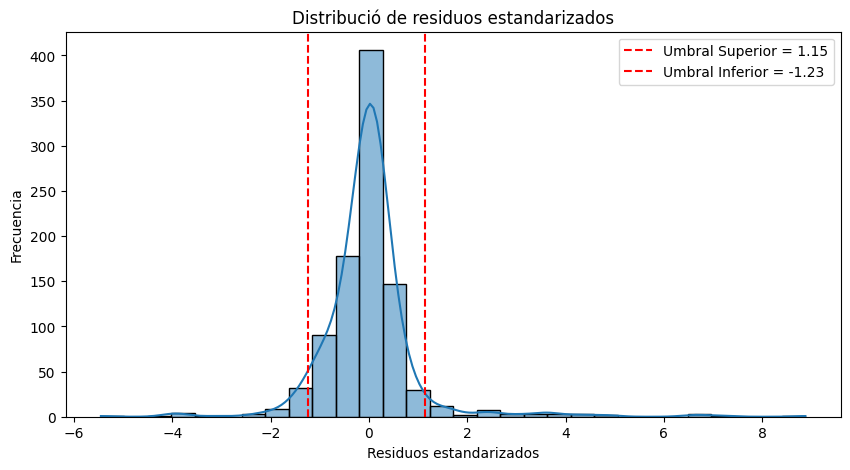

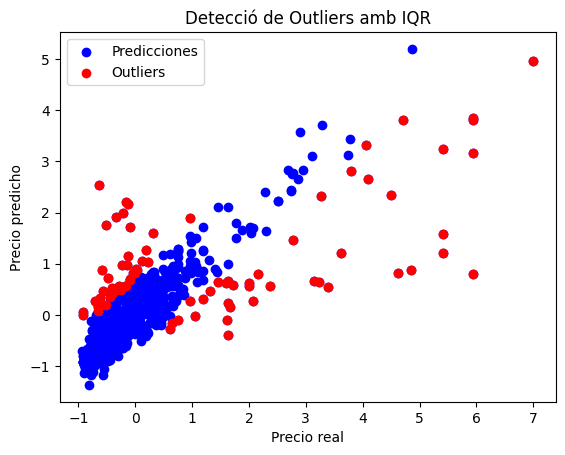

In [81]:
df = df_normalitzat.copy()

X = df.drop(columns=["precio_actual"])
y = df["precio_actual"]

model = LinearRegression()
scaler_residuos = StandardScaler()

model.fit(X, y)
y_pred = model.predict(X)

residuos = y - y_pred
residuos_scaled = scaler_residuos.fit_transform(residuos.values.reshape(-1, 1))

Q1 = np.percentile(residuos_scaled, 25)
Q3 = np.percentile(residuos_scaled, 75)
IQR = Q3 - Q1
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR

print(f"Umbral amb IQR: Inferior={umbral_inferior:.2f}, Superior={umbral_superior:.2f}")

outliers = (residuos_scaled < umbral_inferior) | (residuos_scaled > umbral_superior)

df_sin_outliers = df[~outliers.squeeze()].copy()
df_solo_outliers = df[outliers.squeeze()].copy()

print(f"Files dataset: {df_sin_outliers.shape[0]}")
print(f"Outliers detectats: {df_solo_outliers.shape[0]}")

plt.figure(figsize=(10,5))
sns.histplot(residuos_scaled, bins=30, kde=True)
plt.axvline(umbral_superior, color='red', linestyle='dashed', label=f'Umbral Superior = {umbral_superior:.2f}')
plt.axvline(umbral_inferior, color='red', linestyle='dashed', label=f'Umbral Inferior = {umbral_inferior:.2f}')
plt.xlabel("Residuos estandarizados")
plt.ylabel("Frecuencia")
plt.title("Distribució de residuos estandarizados")
plt.legend()
plt.show()

plt.scatter(y, y_pred, label="Predicciones", color='blue')
plt.scatter(y[outliers.squeeze()], y_pred[outliers.squeeze()], label="Outliers", color='red')
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Detecció de Outliers amb IQR")
plt.legend()
plt.show()

In [82]:

df_normal = df_sin_outliers.copy()

# Desnormalizar las columnas numéricas
df_normal[data.select_dtypes(include=['number']).columns] = scaler_datos.inverse_transform(
    df_normal[data.select_dtypes(include=['number']).columns]
)

# Reconstruir variables categóricas desde OneHotEncoding
categorical_decoded = pd.DataFrame(
    encoder_ohe.inverse_transform(df_normal[df_onehot.columns]),
    columns=encoder_ohe.feature_names_in_,
    index=df_normal.index
)

# Eliminar columnas codificadas y reemplazarlas con las originales
df_normal = df_normal.drop(columns=df_onehot.columns)
df_normal = pd.concat([df_normal, categorical_decoded], axis=1)

# Ordenar columnas como en el dataset original
df_normal = df_normal[data.columns]

# Mostrar el dataset restaurado
print(df_normal)


               ano  almacenamiento     marca  pantalla_in pantalla_tipo  \
_id                                                                       
B00IRZ8EQC  2013.0           256.0   samsung         4.30           lcd   
B00J8OA220  2024.0           160.0  inmarsat         2.00           lcd   
B00JC8MD7Y  2024.0           256.0   samsung         6.70   superamoled   
B00TKALUDC  2015.0           128.0    ttfone         2.00           lcd   
B00TUXHZTW  2015.0           128.0      doro         2.00           lcd   
...            ...             ...       ...          ...           ...   
B0DH3N1GZ3  2024.0           128.0     honor         6.56           lcd   
B09QH71RZR  2024.0           128.0    xiaomi         6.43        amoled   
B0DK4NBZWB  2024.0           256.0      oppo         6.67        amoled   
B0D8TCGKGN  2024.0           256.0   oukitel         6.52            hd   
B0DGXZK6LX  2024.0           256.0       tcl         6.70           lcd   

            velocidad_cp

In [83]:
df_normal.to_csv("../res/dataset_final.csv", index=True)